In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mtalbert = pd.read_csv('../Data/soil data/mtalbert-648717-20241008172730/MtAlbert_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Timestamp (UTC+12:00),SoilMoisture(%),SoilTemp(c),Rain(mm)
0,2018-07-07 11:15:00,37.364,10.4,0.0
1,2018-07-07 11:30:00,37.594,10.4,0.0
2,2018-07-07 11:45:00,37.590,10.4,0.0
3,2018-07-07 12:00:00,37.587,10.5,0.0
4,2018-07-07 12:15:00,37.584,10.5,0.0


# AR with statsmodels

In [2]:
from statsmodels.tsa.ar_model import AR, ARResults

In [3]:
mtalbert.index.freq='h'
mtalbert.head()


,Timestamp (UTC+12:00),SoilMoisture(%),SoilTemp(c),Rain(mm)
0,2018-07-07 11:15:00,37.364,10.4,0.0
1,2018-07-07 11:30:00,37.594,10.4,0.0
2,2018-07-07 11:45:00,37.590,10.4,0.0
3,2018-07-07 12:00:00,37.587,10.5,0.0
4,2018-07-07 12:15:00,37.584,10.5,0.0


In [4]:
mtalbert.set_index('Timestamp (UTC+12:00)', inplace=True)

mtalbert = mtalbert.resample('H').agg({
    'SoilMoisture(%)': 'mean',
    'SoilTemp(c)': 'mean',
    'Rain(mm)': 'sum'
})
mtalbert.head()


C:\Users\Ying\AppData\Local\Temp\ipykernel_3336\1983111797.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mtalbert = mtalbert.resample('H').agg({


,SoilMoisture(%),SoilTemp(c),Rain(mm)
Timestamp (UTC+12:00),,,
2018-07-07 11:00:00,37.51600,10.400,0.0
2018-07-07 12:00:00,37.52375,10.600,0.0
2018-07-07 13:00:00,37.57200,10.700,0.0
2018-07-07 14:00:00,37.34300,10.725,0.0
2018-07-07 15:00:00,37.35050,10.950,0.0


In [5]:
mtalbert.isna().sum()


SoilMoisture(%)    8265
SoilTemp(c)        8265
Rain(mm)              0
dtype: int64

<Axes: xlabel='Timestamp (UTC+12:00)'>

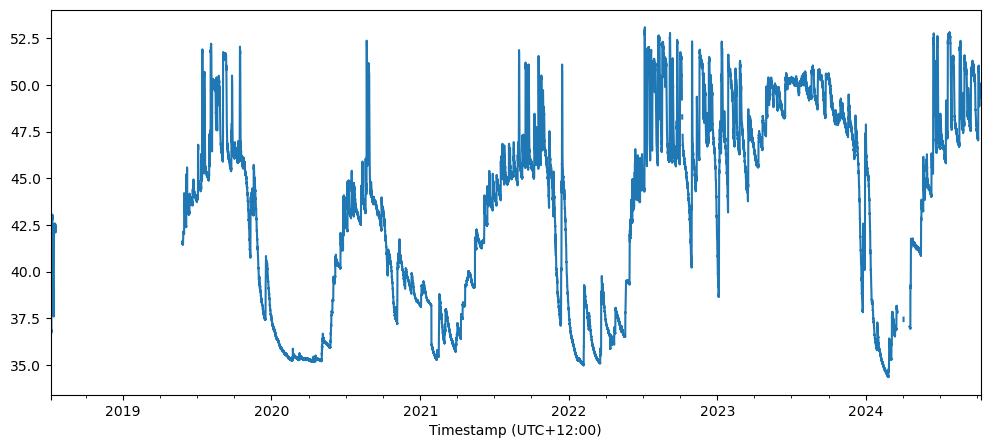

In [6]:
mtalbert['SoilMoisture(%)'].plot(figsize=(12,5))

In [7]:
mtalbert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54854 entries, 2018-07-07 11:00:00 to 2024-10-09 00:00:00
Freq: h
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SoilMoisture(%)  46589 non-null  float64
 1   SoilTemp(c)      46589 non-null  float64
 2   Rain(mm)         54854 non-null  float64
dtypes: float64(3)
memory usage: 1.7 MB


In [8]:
46589  * 85/100

39600.65

In [9]:
mtalbert.iloc[[39600]]

,SoilMoisture(%),SoilTemp(c),Rain(mm)
Timestamp (UTC+12:00),,,
2023-01-12 11:00:00,51.9795,21.2,0.0


In [10]:
# Train test split

train_data = mtalbert.iloc[:39600]
test_data = mtalbert.iloc[39601:]

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
24*28


672

- 24: This corresponds to 1 day (24 hours).
- 72: This corresponds to 3 days (72 hours).
- 168: This corresponds to 7 days (1 week).
- 336: This corresponds to 14 days (2 weeks).
- 504: This corresponds to 21 days (3 weeks).
- 672: This corresponds to 28 days (4 weeks).

In [13]:
print(train_data['SoilMoisture(%)'].isnull().sum())


7505


In [14]:
train_data['SoilMoisture(%)'] = train_data['SoilMoisture(%)'].fillna(method='ffill')
train_data = train_data.dropna(subset=['SoilMoisture(%)'])


In [15]:
from statsmodels.tsa.ar_model import AutoReg

ARmodel1 = AutoReg(train_data['SoilMoisture(%)'], lags=[24,72, 168, 336, 504, 672], trend='c')

In [16]:
print(train_data['SoilMoisture(%)'].isnull().sum())


0


In [17]:
AR_fit = ARmodel1.fit()

In [18]:
AR_fit.ar_lags

[24, 72, 168, 336, 504, 672]

In [19]:
mean_soil_moisture = train_data['SoilMoisture(%)'].mean()
print(mean_soil_moisture)

42.08035228184638


In [20]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['SoilMoisture(%)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.9560803995758906
p-value: 0.001658777544941454


In [21]:
start = len(train_data)
end = len(train_data) + len(test_data) -1

In [22]:
start

39600

In [23]:
end

54852

In [24]:
predictions1 = AR_fit.predict(start=start, end=end)
print(predictions1)

2023-01-12 11:00:00    51.473125
2023-01-12 12:00:00    51.407702
2023-01-12 13:00:00    51.367572
2023-01-12 14:00:00    51.237696
2023-01-12 15:00:00    51.158753
                         ...    
2024-10-08 19:00:00    42.767814
2024-10-08 20:00:00    42.768356
2024-10-08 21:00:00    42.768148
2024-10-08 22:00:00    42.767646
2024-10-08 23:00:00    42.767856
Freq: h, Length: 15253, dtype: float64


In [25]:
predictions1 = predictions1.rename('AR1 Predictions')
predictions1

2023-01-12 11:00:00    51.473125
2023-01-12 12:00:00    51.407702
2023-01-12 13:00:00    51.367572
2023-01-12 14:00:00    51.237696
2023-01-12 15:00:00    51.158753
                         ...    
2024-10-08 19:00:00    42.767814
2024-10-08 20:00:00    42.768356
2024-10-08 21:00:00    42.768148
2024-10-08 22:00:00    42.767646
2024-10-08 23:00:00    42.767856
Freq: h, Name: AR1 Predictions, Length: 15253, dtype: float64

<Axes: xlabel='Timestamp (UTC+12:00)'>

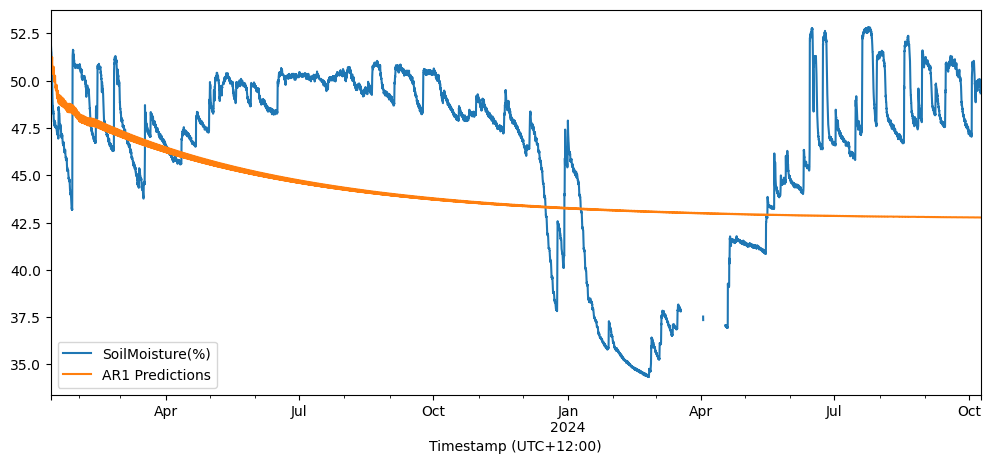

In [26]:
test_data['SoilMoisture(%)'].plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)

Pmdarima

In [27]:
mtalbert_day = pd.read_csv('../Data/soil data/mtalbert-648717-20241008172730/MtAlbert_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
mtalbert_day.head()

,Timestamp (UTC+12:00),SoilMoisture(%),SoilTemp(c),Rain(mm)
0,2018-07-07 11:15:00,37.364,10.4,0.0
1,2018-07-07 11:30:00,37.594,10.4,0.0
2,2018-07-07 11:45:00,37.590,10.4,0.0
3,2018-07-07 12:00:00,37.587,10.5,0.0
4,2018-07-07 12:15:00,37.584,10.5,0.0


In [28]:
# mtalbert_day.set_index('Timestamp (UTC+12:00)', inplace=True)

# mtalbert_daily = mtalbert.resample('D').agg({
#     'SoilMoisture(%)': 'mean',
#     'SoilTemp(c)': 'mean',
#     'Rain(mm)': 'sum'
# })
# mtalbert_daily.head()

In [29]:

mtalbert_day.index.freq = 'D'

In [30]:
mtalbert_day.head()

,Timestamp (UTC+12:00),SoilMoisture(%),SoilTemp(c),Rain(mm)
0,2018-07-07 11:15:00,37.364,10.4,0.0
1,2018-07-07 11:30:00,37.594,10.4,0.0
2,2018-07-07 11:45:00,37.590,10.4,0.0
3,2018-07-07 12:00:00,37.587,10.5,0.0
4,2018-07-07 12:15:00,37.584,10.5,0.0


In [31]:
from pmdarima import auto_arima

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
stepwise_fit= auto_arima(mtalbert_day['SoilMoisture(%)'], start_p=0, max_p=6, max_q=3, seasonal=False)

In [34]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               186297
Model:               SARIMAX(2, 1, 1)   Log Likelihood              225636.431
Date:                Sun, 20 Oct 2024   AIC                        -451264.862
Time:                        22:27:14   BIC                        -451224.321
Sample:                             0   HQIC                       -451252.893
                             - 186297                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8400      0.002    406.775      0.000       0.836       0.844
ar.L2          0.0835      0.001    122.101      0.000       0.082       0.085
ma.L1         -0.8800      0.002   -440.082      0.000      -0.884      -0.876
sigma2         0.0052   2.14e-06   2423.014      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         266248674.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             6.20
Prob(H) (two-sided):                  0.00   Kurtosis:                       187.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""